In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# --- GRR Primitives ---
def grr_perturb(x, domain, epsilon):
    domain = list(domain)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    domain = list(domain)
    n = len(reports)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    q = 1.0 / (exp_eps + k - 1)

    counts = {v: 0 for v in domain}
    for r in reports:
        if r in counts:
            counts[r] += 1
        else:
            raise ValueError(f"Reported value '{r}' not in domain")

    return {v: (counts[v] - n * q) / (n * (p - q)) for v in domain}

In [57]:
def random_split_perturb(df, epsilon):
    """
    Each user perturbs all attributes using equal budget split.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    perturbed = []

    for _, row in df.iterrows():
        noisy_row = [
            grr_perturb(row[col], df[col].unique(), eps_attr)
            for col in df.columns
        ]
        perturbed.append(noisy_row)
    
    return perturbed

def random_split_estimate(reports, df, epsilon):
    """
    Estimate frequencies for each attribute independently.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    reports = np.array(reports)
    estimates = {}

    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        col_reports = reports[:, i]
        estimates[col] = grr_estimate_frequencies(col_reports, domain, eps_attr)

    return estimates


In [125]:
def rs_fd_perturb(df, domains, epsilon):
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    cols = list(domains.keys())
    
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        output = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                output[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                output[col] = np.random.choice(domain)
        privatized.append(output)
    
    return pd.DataFrame(privatized, index=df.index)


def rs_fd_estimate(perturbed_df, domains, epsilon):
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(epsilon_prime) / (np.exp(epsilon_prime) + kj - 1)
        q = 1.0 / (np.exp(epsilon_prime) + kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()

        est = {}
        for v in domain:
            Ni = counts.get(v, 0)
            est[v] = (Ni * d * kj - n * (d - 1 + q * kj)) / (n * kj * (p - q))
        estimates[col] = est

    return estimates




In [130]:
def rs_rfd_perturb(df, domains, priors, epsilon):
    """
    RS+RFD[GRR] client-side perturbation.

    Args:
        df       : DataFrame of true user data.
        domains  : dict mapping each attribute to its domain.
        priors   : dict of prior distributions (same structure as output of get_true_frequencies).
        epsilon  : privacy budget.

    Returns:
        DataFrame of privatized data.
    """
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    cols = list(df.columns)
    epsilon_prime = epsilon
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)  # index of sampled attribute
        y = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                # Sanitize sampled attribute with GRR
                y[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                # Fake value sampled from prior
                prior_probs = [priors[col].get(v, 0.0) for v in domain]
                prior_probs = np.array(prior_probs)
                prior_probs /= prior_probs.sum()  # ensure normalization
                y[col] = np.random.choice(domain, p=prior_probs)
        privatized.append(y)

    return pd.DataFrame(privatized, index=df.index)
def rs_rfd_estimate(perturbed_df, domains, priors, epsilon):
    """
    RS+RFD[GRR] server-side frequency estimator.

    Args:
        perturbed_df : output of rs_rfd_perturb.
        domains      : dict of attribute → domain list.
        priors       : dict of attribute → {value: prior prob}.
        epsilon      : same ε used in perturbation.

    Returns:
        dict of attribute → {value: estimated frequency}.
    """
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        exp_eps = np.exp(epsilon_prime)
        p = exp_eps / (exp_eps + kj - 1)
        q = (1 - p) / (kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()
        est = {}
        for v in domain:
            C_vi = counts.get(v, 0)
            f_prior = priors[col].get(v, 0.0)
            bias = q + (d - 1) * f_prior
            numerator = d * C_vi - n * bias
            denominator = n * (p - q)
            est[v] = numerator / denominator
        estimates[col] = est

    return estimates


In [131]:
# --- True Frequency Utility ---
def get_true_frequencies(df, columns):
    freq_dict = {}
    for col in columns:
        counts = df[col].value_counts(normalize=True).sort_index()
        freq_dict[col] = counts.to_dict()
    return freq_dict

def correlated_data_generator(domain, n, correlations=None, total_attributes=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    domain = list(domain)
    domain_set = {x: [d for d in domain if d != x] for x in domain}
    df = pd.DataFrame()

    # Add correlated attributes
    if correlations:
        for attr1, attr2, p_same in correlations:
            X1 = np.random.choice(domain, size=n)
            mask = np.random.rand(n) < p_same
            X2 = np.where(mask, X1, [np.random.choice(domain_set[v]) for v in X1])
            df[attr1] = X1
            df[attr2] = X2

    # Decide which attributes to include
    if total_attributes is not None:
        all_attrs = [f'X{i+1}' for i in range(total_attributes)]
    else:
        all_attrs = list(df.columns)

    for attr in all_attrs:
        if attr not in df.columns:
            df[attr] = np.random.choice(domain, size=n)

    return df

# domain = [0, 1, 2, 3]
# correlations = [('X1', 'X2', 0.9), ('X3', 'X4', 0.9)]

# df = correlated_data_generator(domain, n=1000, correlations=correlations, total_attributes=2, seed=42)
# print(df.columns)  # ['X1', 'X2']
# print(df.head())

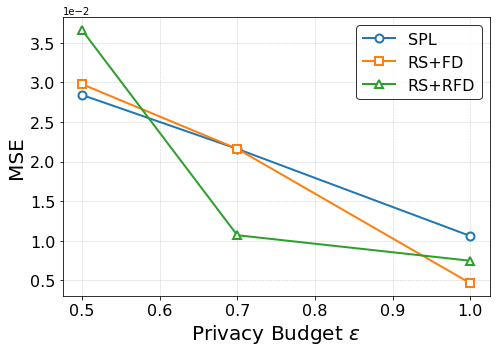

In [142]:
#Atleast  n=10000 when eps = 0.5 and 2 attributes
#Atleast  n=10000 when eps = 0.2 and 2 attributes
#Atleast  n=100000 when eps = 0.1 and 2 attributes, that means we have to increase the number of users substantially

#Atleast  n=50000 when eps = 0.5 and 4 attributes

# 1) Generate data
domain = list(range(10))
correlations = [('X1', 'X2', 0.9), ('X3', 'X4', 0.9)]
df = correlated_data_generator(domain, n=10000, correlations=correlations)

# 2) Setup
columns = df.columns.tolist()
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs  # For RS+RFD, use true distribution as prior
domain_sorted = sorted(domain)
epsilons = [0.5, 0.7, 1]
domains = {col: sorted(df[col].unique()) for col in df.columns}

mse_spl = []
mse_rsfd = []
mse_rsrfd = []

# 3) Compute MSEs
for eps in epsilons:
    # --- SPL ---
    pert_spl = random_split_perturb(df, eps)
    est_spl = random_split_estimate(pert_spl, df, eps)
    mse_spl_attrs = []
    for col in columns:
        mse = np.mean([
            (est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0)) ** 2
            for v in domain_sorted
        ])
        mse_spl_attrs.append(mse)
    mse_spl.append(np.mean(mse_spl_attrs))

    # --- RS+FD ---
    pert_rsfd = rs_fd_perturb(df, domains, eps)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, eps)
    mse_rsfd_attrs = []
    for col in columns:
        mse = np.mean([
            (est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0)) ** 2
            for v in domain_sorted
        ])
        mse_rsfd_attrs.append(mse)
    mse_rsfd.append(np.mean(mse_rsfd_attrs))

    # --- RS+RFD ---
    pert_rsrfd = rs_rfd_perturb(df, domains, priors, eps)
    est_rsrfd = rs_rfd_estimate(pert_rsrfd, domains, priors, eps)
    mse_rsrfd_attrs = []
    for col in columns:
        mse = np.mean([
            (est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0)) ** 2
            for v in domain_sorted
        ])
        mse_rsrfd_attrs.append(mse)
    mse_rsrfd.append(np.mean(mse_rsrfd_attrs))

# 4) Plot
plt.figure(figsize=(7, 5))

plt.plot(
    epsilons, mse_spl,
    linewidth=2, marker='o', markersize=8,
    markeredgewidth=2, markerfacecolor='white',
    label='SPL'
)

plt.plot(
    epsilons, mse_rsfd,
    linewidth=2, marker='s', markersize=8,
    markeredgewidth=2, markerfacecolor='white',
    label='RS+FD'
)

plt.plot(
    epsilons, mse_rsrfd,
    linewidth=2, marker='^', markersize=8,
    markeredgewidth=2, markerfacecolor='white',
    label='RS+RFD'
)

plt.xlabel(r'Privacy Budget $\epsilon$', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(fontsize=16, loc='upper right', frameon=True, edgecolor='black')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [123]:
# 1) Generate data

#Atleast  n=10000 when eps = 0.5 and 2 attributes
#Atleast  n=10000 when eps = 0.2 and 2 attributes
#Atleast  n=100000 when eps = 0.1 and 2 attributes, that means we have to increase the number of users substantially

#Atleast  n=50000 when eps = 0.5 and 4 attributes

domain = list(range(2))
correlations = [('X1', 'X2', 0.9), ('X3', 'X4', 0.9)]
df = correlated_data_generator(domain, n=50000, correlations=correlations)

# Setup
columns = df.columns.tolist()
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domains = {col: sorted(df[col].unique()) for col in columns}
epsilons = [0.1 0.2]
sample_eps = 0.5
sample_col = 'X1'
sample_val = 1

# Run perturbation
pert_rsfd = rs_fd_perturb(df, domains, sample_eps)
pert_rsrfd = rs_rfd_perturb(df, domains, priors, sample_eps)

# ---- DIAGNOSTICS ----
print("\n========== RS+RFD DIAGNOSTICS ==========")

# 1. Prior distribution check
print("\n--- Prior Distributions ---")
for col in columns:
    print(f"{col} → {priors[col]}")

# 2. Amplified ε′
d = len(columns)
print("\n--- Amplified ε′ Values ---")
for eps in epsilons:
    eps_prime = np.log(d * (np.exp(eps) - 1) + 1)
    print(f"ε = {eps}, Amplified ε′ = {eps_prime:.4f}")

# # 3. GRR parameters
# print("\n--- GRR Flip Probabilities ---")
# for eps in epsilons:
#     eps_prime = np.log(d * (np.exp(eps) - 1) + 1)
#     kj = len(domains[sample_col])
#     p = np.exp(eps_prime) / (np.exp(eps_prime) + kj - 1)
#     q = (1 - p) / (kj - 1)
#     print(f"ε = {eps}, p = {p:.4f}, q = {q:.4f}, p-q = {p - q:.4f}")

# # 4. Value counts
# print(f"\n--- Value Counts in {sample_col} ---")
# print("RS+FD:")
# print(pert_rsfd[sample_col].value_counts())
# print("\nRS+RFD:")
# print(pert_rsrfd[sample_col].value_counts())

# Common variables
n = len(df)
kj = len(domains[sample_col])
eps_prime = np.log(d * (np.exp(sample_eps) - 1) + 1)
p = np.exp(eps_prime) / (np.exp(eps_prime) + kj - 1)
q = (1 - p) / (kj - 1)
true_val = true_freqs[sample_col].get(sample_val, 0.0)

# 5. Estimator Breakdown for RS+RFD
print("\n--- Estimator Breakdown for RS+RFD ---")
C_vi = pert_rsrfd[sample_col].value_counts().get(sample_val, 0)
f_prior = priors[sample_col].get(sample_val, 0.0)
numerator_rfd = d * C_vi - n * (q + (d - 1) * f_prior)
denominator = n * (p - q)
estimate_rfd = numerator_rfd / denominator

# print(f"Attribute: {sample_col}, Value: {sample_val}")
# print(f"C(v) = {C_vi}")
# print(f"f̃(v) = {f_prior:.4f}")
# print(f"Numerator = {numerator_rfd:.4f}")
# print(f"Denominator = {denominator:.4f}")
# print(f"RS+RFD Estimate = {estimate_rfd:.4f}")
# print(f"True Frequency = {true_val:.4f}")

# 6. Estimator Breakdown for RS+FD
print("\n--- Estimator Breakdown for RS+FD ---")
C_vi_fd = pert_rsfd[sample_col].value_counts().get(sample_val, 0)
numerator_fd = C_vi_fd * d * kj - n * (d - 1 + q * kj)
denominator_fd = n * kj * (p - q)
estimate_fd = numerator_fd / denominator_fd

# print(f"Attribute: {sample_col}, Value: {sample_val}")
# print(f"C(v) = {C_vi_fd}")
# print(f"q = {q:.4f}, kj = {kj}, d = {d}")
# print(f"Numerator = {numerator_fd:.4f}")
# print(f"Denominator = {denominator_fd:.4f}")
# print(f"RS+FD Estimate = {estimate_fd:.4f}")
# print(f"True Frequency = {true_val:.4f}")


# 7. Estimator Breakdown for SPL
print("\n--- Estimator Breakdown for SPL ---")

# Perturb SPL: each attribute perturbed with ε/d
eps_split = sample_eps / d
pert_spl = []
for _, row in df.iterrows():
    spl_row = {}
    for col in columns:
        domain = domains[col]
        spl_row[col] = grr_perturb(row[col], domain, eps_split)
    pert_spl.append(spl_row)
pert_spl = pd.DataFrame(pert_spl, index=df.index)

# Estimate using GRR
counts_spl = pert_spl[sample_col].value_counts().to_dict()
C_vi_spl = counts_spl.get(sample_val, 0)

p_spl = np.exp(eps_split) / (np.exp(eps_split) + kj - 1)
q_spl = 1.0 / (np.exp(eps_split) + kj - 1)
numerator_spl = C_vi_spl - n * q_spl
denominator_spl = n * (p_spl - q_spl)
estimate_spl = numerator_spl / denominator_spl

# print(f"Attribute: {sample_col}, Value: {sample_val}")
# print(f"C(v) = {C_vi_spl}")
# print(f"ε_split = {eps_split:.4f}, p = {p_spl:.4f}, q = {q_spl:.4f}, p-q = {p_spl - q_spl:.4f}")
# print(f"Numerator = {numerator_spl:.4f}")
# print(f"Denominator = {denominator_spl:.4f}")
#print(f"SPL Estimate = {estimate_spl:.4f}")
print(f"True Frequency = {true_val:.4f}")
print(f"SPL Estimate = {estimate_spl:.4f}")
print(f"RS+FD Estimate = {estimate_fd:.4f}")
print(f"RS+RFD Estimate = {estimate_rfd:.4f}")



========== RS+RFD DIAGNOSTICS ==========

--- Prior Distributions ---
X1 → {0: 0.4994, 1: 0.5006}
X2 → {0: 0.50144, 1: 0.49856}
X3 → {0: 0.50058, 1: 0.49942}
X4 → {0: 0.49922, 1: 0.50078}

--- Amplified ε′ Values ---
ε = 0.1, Amplified ε′ = 0.3511
ε = 0.2, Amplified ε′ = 0.6343

--- Estimator Breakdown for RS+RFD ---

--- Estimator Breakdown for RS+FD ---

--- Estimator Breakdown for SPL ---
True Frequency = 0.5006
SPL Estimate = 0.5019
RS+FD Estimate = 0.5075
RS+RFD Estimate = 0.5006


In [124]:
#Atleast  n=10000 when eps = 0.5 and 2 attributes
#Atleast  n=10000 when eps = 0.2 and 2 attributes
#Atleast  n=100000 when eps = 0.1 and 2 attributes, that means we have to increase the number of users substantially

#Atleast  n=50000 when eps = 0.5 and 4 attributes